# 변수중요도 : Feature Importance



## 1.환경준비

### 1) 라이브러리 로딩

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

### 2) 데이터 로딩

In [16]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 산업단지 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사 1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

### 3) 필요한 함수 생성

In [17]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

## 2.데이터 준비


### 1) x, y로 나누기 

In [18]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

### 3) train : validation 분할

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2022)
x_train.shape

(404, 13)

## 3.Feature Importance

### 1) Decision Tree

In [21]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import * 

* 기본 모델

In [22]:
model = DecisionTreeRegressor(max_depth = 3)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3)

* 모델 시각화

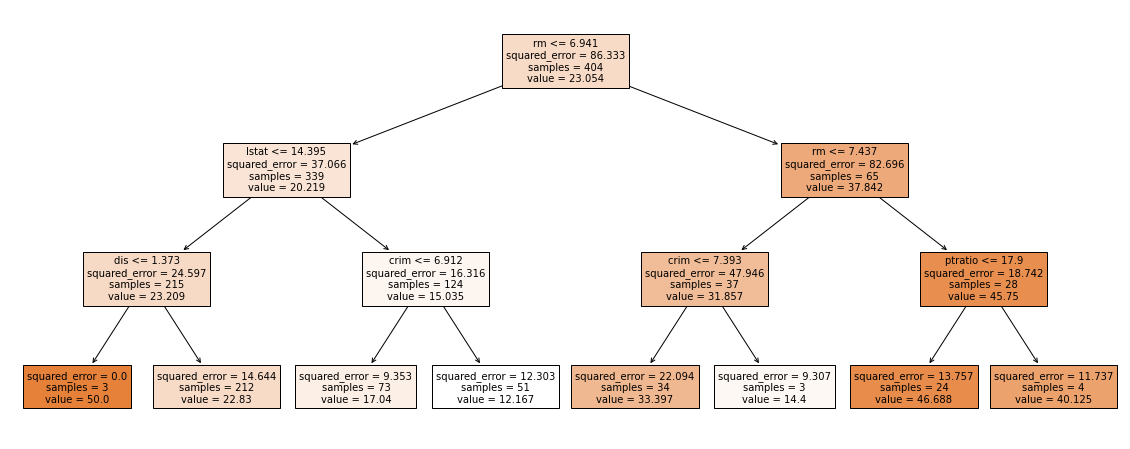

In [23]:
plt.figure(figsize = (20, 8))
plot_tree(model, feature_names = x.columns,
          filled = True, fontsize = 10);

* 변수 중요도

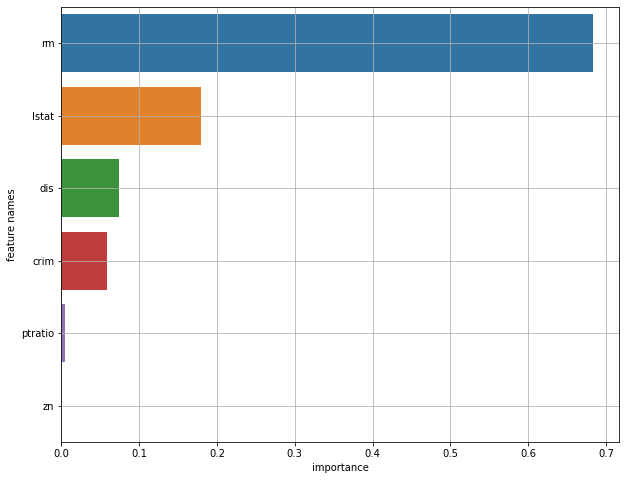

In [24]:
result = plot_feature_importance(model.feature_importances_, list(x), 6)

In [25]:
result

,feature_names,feature_importance
0,rm,0.682914
1,lstat,0.179261
2,dis,0.074513
3,crim,0.058274
4,ptratio,0.005038
5,zn,0.000000


* 성능 최적화 이후 변수 중요도 다시 확인

In [26]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':range(1, 10)}
model = DecisionTreeRegressor()
model_gs = GridSearchCV(model, params, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 10)})

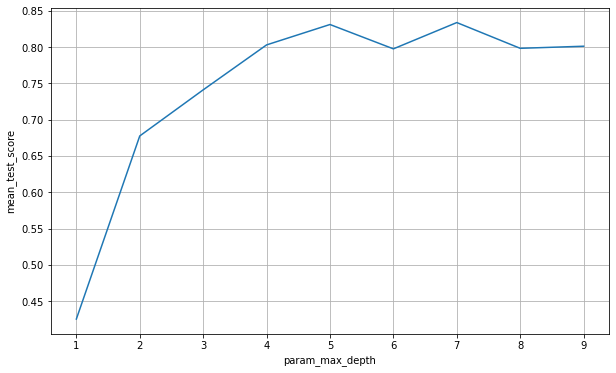

In [27]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(model_gs.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

In [28]:
best_model = model_gs.best_estimator_

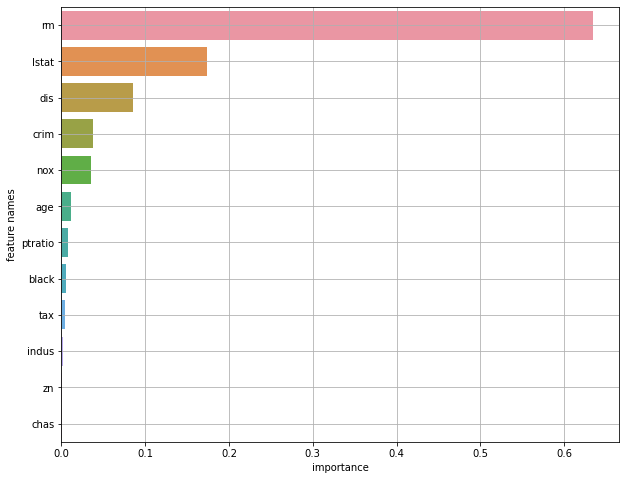

In [29]:
result = plot_feature_importance(best_model.feature_importances_, list(x),12)

In [30]:
# pred = model_gs.predict(x_val)
pred = best_model.predict(x_val)
print(mean_absolute_error(y_val, pred))

2.7182119536551834


### 2) Random Forest

* 기본모델링

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
n_est = 3
model = RandomForestRegressor(n_estimators = n_est, max_depth = 2)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=3)

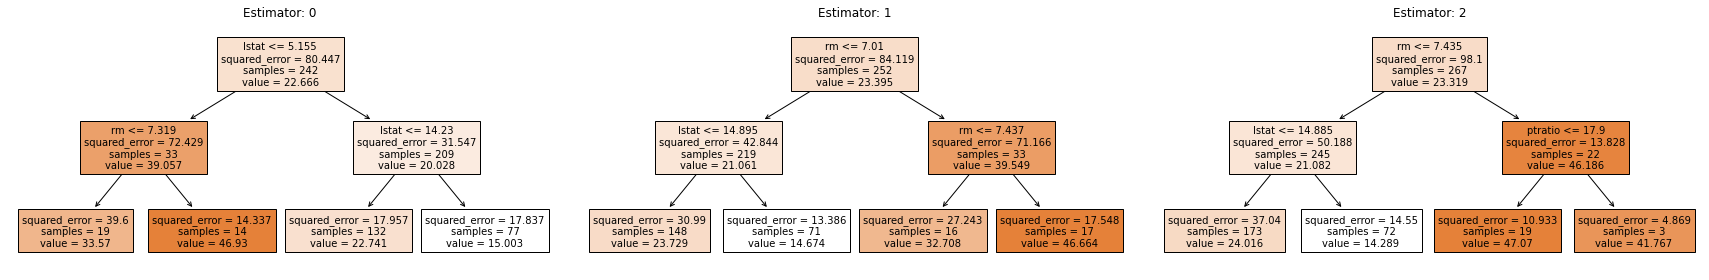

In [33]:
fn=list(x_train)
cn=["0","1"]
fig, axes = plt.subplots(nrows = 1,ncols = n_est,figsize = (24,4))
for index in range(0, n_est):
    plot_tree(model.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True, fontsize = 10,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 12)
    
plt.tight_layout()
plt.show()

In [34]:
fi = x_train.iloc[0:0]
for i in range(n_est) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [35]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.0,0.0,0.0,0.0,0.0,0.098232,0.0,0.0,0.0,0.0,0.000000,0.0,0.901768
1,0.0,0.0,0.0,0.0,0.0,0.746493,0.0,0.0,0.0,0.0,0.000000,0.0,0.253507
2,0.0,0.0,0.0,0.0,0.0,0.734362,0.0,0.0,0.0,0.0,0.004997,0.0,0.260641


In [36]:
fi.mean(axis = 0)

crim       0.000000
zn         0.000000
indus      0.000000
chas       0.000000
nox        0.000000
rm         0.526363
age        0.000000
dis        0.000000
rad        0.000000
tax        0.000000
ptratio    0.001666
black      0.000000
lstat      0.471972
dtype: float64

In [37]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.0,0.0,0.0,0.0,0.0,0.526363,0.0,0.0,0.0,0.0,0.001666,0.0,0.471972


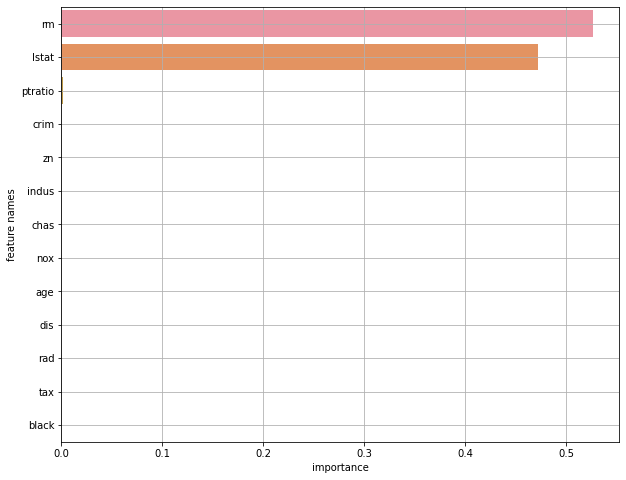

In [38]:
result = plot_feature_importance(model.feature_importances_, list(x))

* tree = 100개 Random Forest 모델 만들기

In [39]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

* 트리 전체 중요도 저장

In [40]:
fi = x_train.iloc[0:0]
for i in range(100) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [41]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.029023,0.000091,0.008147,0.000760,0.011509,0.678315,0.016440,0.044647,0.004247,0.002414,0.010507,0.010598,0.183301
1,0.036353,0.000116,0.002416,0.000016,0.001016,0.146869,0.019158,0.012925,0.002290,0.002138,0.028651,0.006869,0.741183
2,0.040190,0.000203,0.002998,0.000274,0.021529,0.688117,0.007003,0.036185,0.002409,0.004550,0.014757,0.006081,0.175705
3,0.030689,0.000200,0.003252,0.000103,0.002423,0.609302,0.012099,0.117960,0.002251,0.001533,0.014757,0.012404,0.193026
4,0.041100,0.000167,0.012301,0.000019,0.002755,0.131276,0.009173,0.115887,0.000211,0.006049,0.011422,0.010596,0.659043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.029869,0.000147,0.004181,0.001133,0.005658,0.613151,0.010107,0.105293,0.001877,0.007177,0.003418,0.012878,0.205110
96,0.026697,0.000261,0.000592,0.000392,0.008985,0.630131,0.014923,0.039410,0.009311,0.003873,0.003602,0.003312,0.258510
97,0.063735,0.001765,0.009432,0.000531,0.010178,0.565698,0.012884,0.097013,0.001167,0.009041,0.012530,0.006466,0.209561
98,0.032657,0.000130,0.009572,0.000000,0.006453,0.699234,0.009848,0.066568,0.000041,0.008619,0.009655,0.008203,0.149020


* 트리 100개의 평균 중요도

In [42]:
fi.mean(axis = 0)

crim       0.036088
zn         0.000831
indus      0.006312
chas       0.000792
nox        0.013043
rm         0.501302
age        0.014458
dis        0.066761
rad        0.003442
tax        0.007926
ptratio    0.011128
black      0.009161
lstat      0.328756
dtype: float64

In [43]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.036088,0.000831,0.006312,0.000792,0.013043,0.501302,0.014458,0.066761,0.003442,0.007926,0.011128,0.009161,0.328756


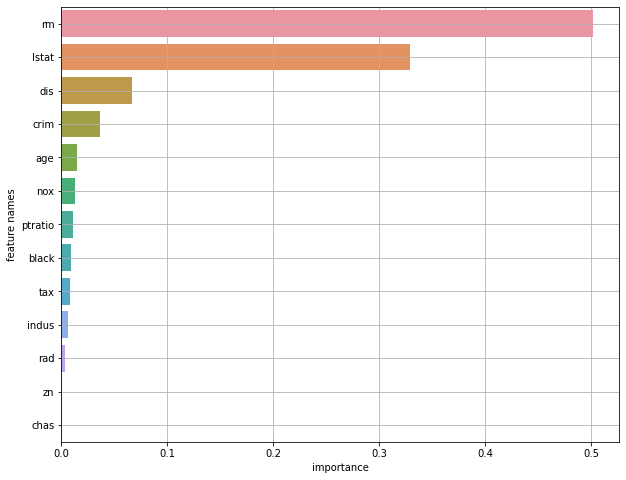

In [44]:
result = plot_feature_importance(model.feature_importances_, list(x))

In [45]:
pred = model.predict(x_val)
print(mean_absolute_error(y_val, pred))

2.4177254901960774


### 3) XGB

In [46]:
from xgboost import XGBRegressor, plot_tree, plot_importance

* 기본 모델링

In [47]:
model = XGBRegressor(n_estimators = 10, max_depth = 2, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

* plot tree
    * plot tree함수는 XGB에서 제공합니다.
    * XGB에서의 트리 시각화는 여러 estimator중 하나씩만 가능합니다.

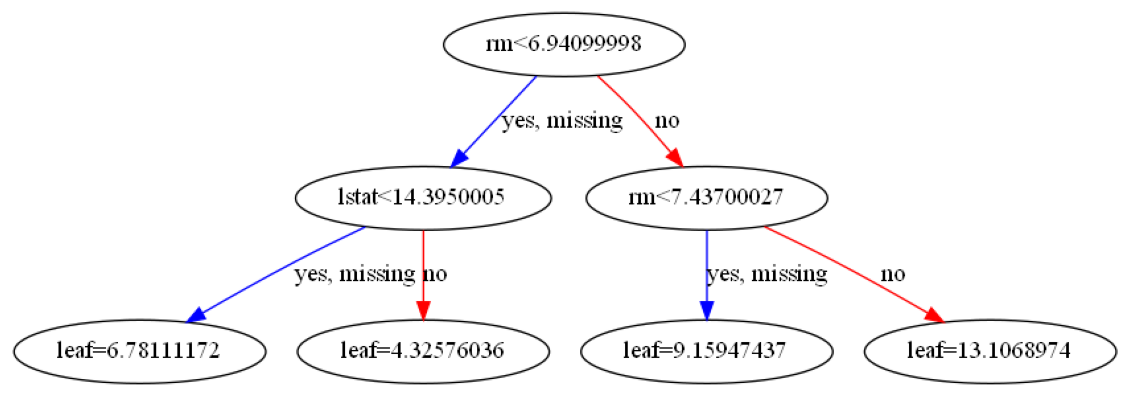

In [48]:
plt.rcParams['figure.figsize'] = 20,20
plot_tree(model)
plt.show()

* leaf 노드의 값 ==> 로지스틱 함수에 넣으면 0~1 사이의 값으로 변환됨.

* 몇가지 옵션
    * num_trees = 0
    * rankdir='LR'

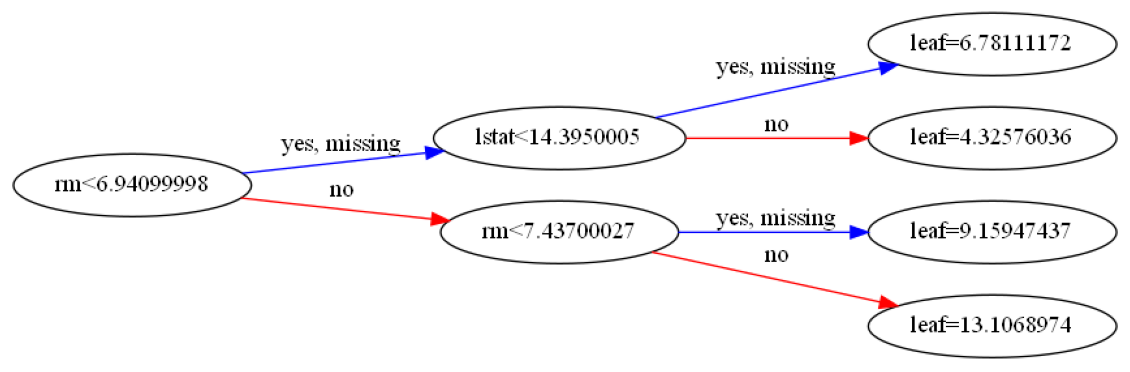

In [49]:
plot_tree(model, num_trees = 0, rankdir = 'LR')
plt.show()

* plot_importance
    * 변수중요도 기본값은 weight

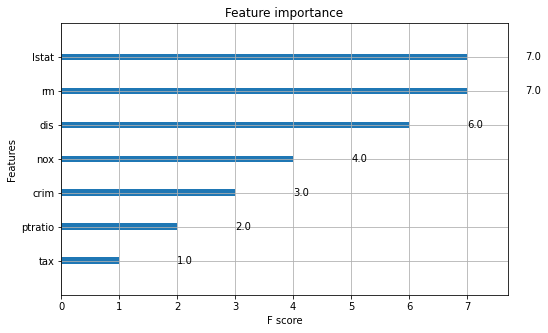

In [50]:
plt.rcParams['figure.figsize'] = 8, 5
plot_importance(model)
plt.show()

* model.feature_importances_ : 변수중요도 기본값은 gain.

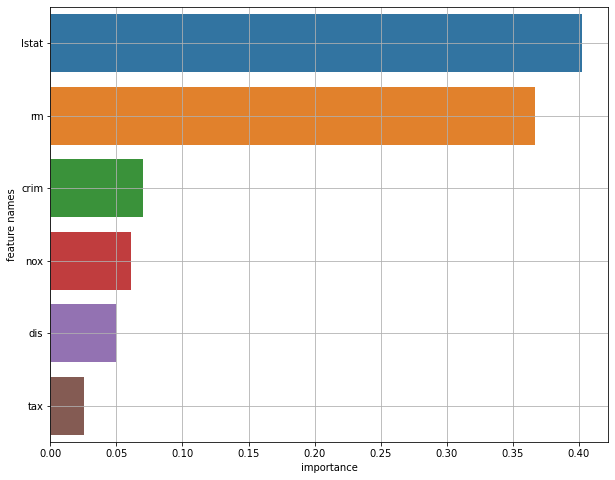

In [51]:
result = plot_feature_importance(model.feature_importances_, list(x),6)

* xgb의 변수 중요도
    * weight : 모델 전체에서 해당 feature가 split될 때 사용된 횟수의 합(plot_tree 에서의 기본값)
    * gain : feature별 평균 imformation gain.(model.feature_importances_ 의 기본값)
    * cover : feature가 split 할때의 샘플 수의 평균.

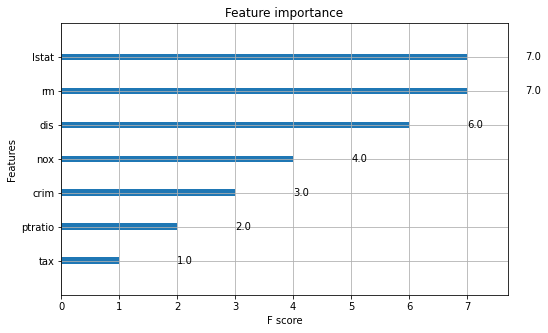

In [52]:
# importance_type='weight'
plot_importance(model)
plt.show()

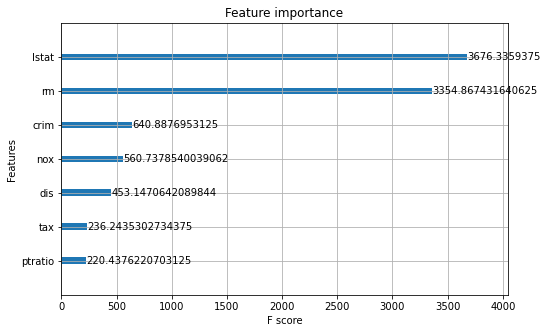

In [53]:
# importance_type='gain'
plot_importance(model, importance_type='gain')
plt.show()

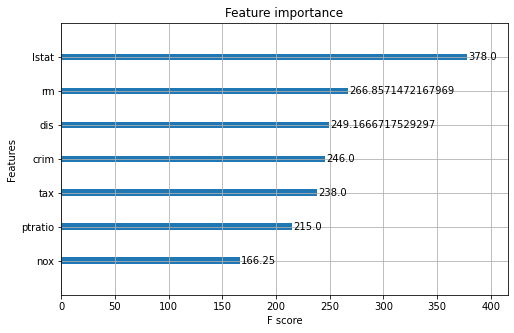

In [54]:
# importance_type='cover'
plot_importance(model, importance_type='cover')
plt.show()

## 4.실습 : 직원 이직 예측모델 변수 중요도 비교

### 4.1 데이터 준비

* 데이터 로딩

In [55]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path)
data.head(10)

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1
5,0,44,Research & Development,2,1,Medical,Male,Manufacturing Director,3,Single,10209,5,2,16,2,2,2
6,0,41,Sales,10,2,Life Sciences,Male,Sales Executive,4,Single,6230,7,4,16,3,3,14
7,0,25,Sales,18,1,Life Sciences,Male,Sales Executive,3,Married,6232,2,2,6,3,2,3
8,0,50,Research & Development,2,3,Medical,Male,Research Director,3,Married,17639,5,4,30,3,3,4
9,0,47,Sales,4,2,Life Sciences,Female,Sales Executive,4,Single,4163,1,3,9,0,3,9


|	변수 명	|	내용	|	구분	|
|	----	|	----	|	----	|
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|
|	Age	|	나이	|	숫자	|
|	BusinessTravel	|	출장 빈도(범주)	|		|
|	Department	|	현 부서	|		|
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|
|	EducationField	|	전공	|		|
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|
|	Gender	|	성별	|		|
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	JobRole	|	직무	|		|
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	MaritalStatus	|	결혼상태	|		|
|	MonthlyIncome	|	월급	|	숫자	|
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|


In [56]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [57]:
y.value_counts() / y.shape[0]

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

* 가변수화 Dummy Variable

In [58]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','JobSatisfaction','MaritalStatus',
              'RelationshipSatisfaction','WorkLifeBalance'] 
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True) 

* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [61]:
print(x_train.shape, x_val.shape)

(920, 38) (230, 38)


* class balance를 맞추기 위한 resampling

In [62]:
import sklearn
sklearn.__version__

'1.1.2'

In [63]:
from imblearn.over_sampling import SMOTE

In [64]:
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

print(np.bincount(y_train))
print(np.bincount(y_train) / y_train.shape[0])

[833 833]
[0.5 0.5]


### 4.2 모델링 with Resampling
> * Resampling(up) 샘플링 데이터를 이용
* DecisionTreeClassifier, RandomForestClassifier, XGBClassifier를 이용하여 모델 생성
* validate set으로 예측하고 평가(classification report)해 봅시다.
* 각각의 변수중요도 비교하기.



* 모델링
    * DecisionTreeClassifier, RandomForestClassifier, XGBClassifier를 이용하여 모델 생성

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

* decision tree

In [66]:
# depth의 범위 1~10까지 안에서 그리드서치로 튜닝해 봅시다.
params= {'max_depth'}


In [67]:
# 튜닝 과정 로그를 df로 저장 합시다.


# 튜닝 결과를 그래프로 그려봅시다.



* rf

In [68]:
# 기본값으로 모델을 생성합니다.



* xgb

In [69]:
# 다음 범위로 그리드서치 튜닝을 진행합시다.
# max_depth : 1~6, learning_rate : 0.01 ~ 0.4, n_estimators : 50~150




* 모델 성능 비교
    * 세 모델 중 성능이 가장 좋은 모델은?

* 변수 중요도 비교 : 세 모델간 변수 중요도를 비교해 봅시다. 

* 변수 중요도의 차이를 통해 무엇을 파악할 수 있나요?

______
